# Entrega 3 - Aprendizaje por Refuerzos

### Grupo 50:
    - M. Ramilo (5.665.788-5)
    - G. Dinello (5.031.022-5)
    - F. Crocamo (4.732.816-6)

## 1. Objetivo

En el contexto del aprendizaje por refuerzos, y considerando el problema de un taxímetro que se mueve en una grilla, donde el vehículo debe recoger al pasajero de una casilla determindada y llevarlo a otra, se busca implementar un agente que aprenda a realizar esta tarea de manera óptima utilizando un algoritmo de Q-Learning.

## 2. Creación de un Ambiente y Exploración

Importamos la biblioteca Gymnassium, que vamos a usar como framework de RL

In [1]:
!pip3 install cmake gymnasium scipy
import gymnasium as gym

Creamos un ambiente y lo mostramos en pantalla. Para esto definimos una función para imprimir nuestro ambiente.

In [2]:
# La semilla usada para crear el ambiente
semilla = 1

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

# Una funcion de ayuda para imprimir el estado de nuestro mundo
def print_env(estado):
  env_str = estado.render()
  print(env_str)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+





El rectángulo de color representa el taxi, amarillo cuando va sin pasajero y verde con pasajero.
'|' representa una pared que el taxi no puede cruzar, es decir.
R, G, Y, B son los puntos de interés, es decir, las posibles ubicaciones de recogida y destino. La letra azul representa la ubicación actual de recogida de pasajeros, y la letra púrpura es el destino actual.

Si cambiamos la semilla, cambia el estado del ambiente.

In [3]:
# Una semilla diferente
semilla = 2

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Exploremos el espacio de estados y de acciones:

In [4]:
print(f"Espacio de Acciones {entorno.action_space}")
print(f"Espacio de Estados {entorno.observation_space}")

Espacio de Acciones Discrete(6)
Espacio de Estados Discrete(500)


Hay 6 acciones, que corresponden a:
 * 0 = ir al Sur
 * 1 = ir al Norte
 * 2 = ir al Este
 * 3 = ir al Oeste
 * 4 = recoger pasajero
 * 5 = dejar pasajero

Los puntos cardinales siguen la convención Norte hacie arriba. Recoger/dejar al pasajero solo tienen efecto si el taxi está en la misma casilla que el pasajero, y en uno de los puntos de interés.

Nuestro agente deberá elegir la acción a tomar en cada paso. Gymnassium nos expone funciones para esto. Si queremos movernos al sur, por ejemplo:

In [5]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)
print_env(entorno)

accion = 0 # Sur
entorno.step(accion)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



Ahora estamos listos para programar un agente. Empezando por uno random. Se puede ejecutar el codigo abajo varias veces para ver como cambia en cada ejecución, debido a que la semilla_acciones es diferente.

In [6]:
import random 

def episodio_random(semilla_ambiente = 1):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env
    entorno.reset(seed = semilla_ambiente)

    iteraciones = 0
    penalizaciones, recompensa = 0, 0

    marcos = [] # para la animación

    termino = False
    truncado = False

    while not termino and not truncado:
        #  selecciona una acción aleatoria del conjunto de todas las posibles acciones
        accion = entorno.action_space.sample() 
        estado, recompensa, termino, truncado, info = entorno.step(accion)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado,
            'accion': accion,
            'recompensa': recompensa
            }
        )

        iteraciones += 1


    print(f"Iteraciones: {iteraciones}")
    print(f"Penalizaciones: {penalizaciones}")

    return marcos

marcos = episodio_random()

Iteraciones: 1104
Penalizaciones: 359


Podemos ver el episodio completo abajo. Notar que seleccionamos la semillia de selector de acciones para que la corrida sea 'buena'.

In [7]:
from IPython.display import clear_output
from time import sleep
import sys

def print_frames(marcos):
    for i, marco in enumerate(marcos):
        clear_output()
        print(marco['marco'])
        print(f"Iteracion: {i + 1}")
        print(f"Estado: {marco['estado']}")
        print(f"Accion: {marco['accion']}")
        print(f"Recompensa: {marco['recompensa']}")
        sys.stdout.flush()
        # Aumentar este tiempo para ver mejor la animación
        sleep(0.005)

print_frames(marcos)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iteracion: 1104
Estado: 0
Accion: 5
Recompensa: 20


## 3. Creación de Agente Inteligente

Ahora queremos programar un agente inteligente, para eso nos vamos a atener a la siguiente interfaz.

In [8]:
class Agente:
    def elegir_accion(self, estado, max_accion) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones"""
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        """Aprender a partir de la tupla 
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
        """
        pass

Para nuestro agente aleatorio, esto sería:

In [9]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # No aprende
        pass

Poniendolo a jugar:

In [10]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env

agente = AgenteAleatorio()

iteraciones = 0
penalizaciones, recompensa = 0, 0

marcos = [] # for animation

termino = False
truncado = False
estado_anterior, info = entorno.reset(seed = semilla)
while not termino and not truncado:
    # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
    accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
    # Realizamos la accion
    estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
    # Le informamos al agente para que aprenda
    agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

    # El agente trato de dejar/recoger al pasajero incorrectamente
    if recompensa == -10:
        penalizaciones += 1

    # Put each rendered frame into dict for animation
    marcos.append({
        'marco': entorno.render(),
        'estado': estado_siguiente,
        'accion': accion,
        'recompensa': recompensa
        }
    )

    estado_anterior = estado_siguiente
    iteraciones += 1


print(f"Iteraciones: {iteraciones}")
print(f"Penalizaciones: {penalizaciones}")

Iteraciones: 4693
Penalizaciones: 1506


Podemos encapsular lo anterior en una función 

In [11]:
def ejecutar_episodio(agente, semilla):
    global marcos
    entorno = gym.make("Taxi-v3", render_mode='ansi').env

    iteraciones = 0
    penalizaciones, recompensa = 0, 0
    marcos = [] # for animation

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed = semilla)
    while not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado_siguiente,
            'accion': accion,
            'recompensa': recompensa
            }
        )

        estado_anterior = estado_siguiente
        iteraciones += 1
    return iteraciones


y correrlo varias veces para ver el rendimiento promedio

In [12]:
agente = AgenteAleatorio()
semilla = 1
num_iteraciones_episodios = []
for i in range(10):
    num_iteraciones = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]

Y obtener métricas al respecto

In [13]:
import numpy
print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")

Se realizaron 1728.3, en promedio


## 4. Implementación de Nuestro Agente

La tarea a realizar consiste en programar un agente de aprendizaje por refuerzos:

### 4.1 
Programar las funciones de la clase AgenteRL, manteniendo cualquier
función adicional necesaria dentro de la clase.

In [14]:
import numpy as np
import random

class AgenteRL(Agente):
    # Agregar código aqui

    def __init__(self, entorno, 
                 p_exploration = 1.00, 
                 min_p_exploration = 0.05, 
                 exploration_rate = 0.05, 
                 gamma = 0.9) -> None:
        super().__init__()
        # Generar tabla con valores Q (estado, accion)
        self.q_table = np.zeros((500, 6))
        # Inicia con explorando 100% (aleatorio)
        self.p_exploration = p_exploration
        # Nivel minimo de exploracion
        self.min_p_exploration = min_p_exploration
        # La exploracion va disminuyendo a medida que aprende
        self.exploration_rate = exploration_rate
        # gamma para calculo de Q
        self.gamma = gamma
    
    def elegir_accion(self, estado, max_accion) -> int:
        # Ver si se toma una accion exploratoria o basada en aprendizaje previo
        if (random.uniform(0, 1) > self.p_exploration):
            # Tomar accion segun valores en tabla Q
            return np.argmax(self.q_table[estado])
        else:
            # Tomar accion al azar
            return random.randrange(max_accion)
    
    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # Disminuir p_exploration si recompensa = 20 (fin de juego)
        if recompensa == 20:
            self.p_exploration = max(self.min_p_exploration, self.p_exploration - self.exploration_rate)
        # Actualizar celda de tabla Q con ecuacion
        self.q_table[estado_anterior][accion] = self.calculate_q(estado_siguiente, recompensa)
    
    def calculate_q(self, estado_siguiente, recompensa) -> int:
        # El proximo V mayor posible para el siguiente estado
        max_q_next_state = np.max(self.q_table[estado_siguiente])
        return recompensa + self.gamma * max_q_next_state

Y ejecutar con el muchos episodios con la misma semilla:

In [15]:
# Advertencia: este bloque es un loop infinito si el agente se deja sin implementar

agente = AgenteRL(entorno)
semilla = 1
num_iteraciones_episodios = []
for i in range(1000):
    num_iteraciones = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]

### 4.2 

Analizar los resultados de la ejecución anterior.

Analizar los resultados de una ejecución de mil episodios con
el agente programado. Agregar un nuevo bloque de texto
discutiendo los resultado obtenidos.

In [16]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def graficar_resultados(num_iteraciones_episodios):
    plt.plot(num_iteraciones_episodios)
    plt.ylabel('Numero de iteraciones')
    plt.xlabel('Episodio')
    plt.xscale('log')
    plt.show()

Se realizaron 19.664, en promedio
Ultima iteracion: 12


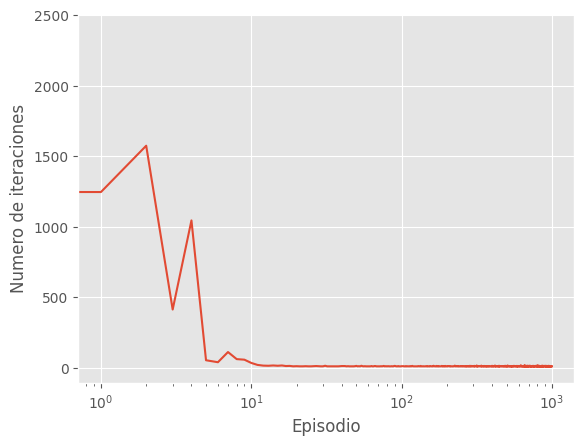

In [17]:
# Analizar los resultados aqui
print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")
print(f"Ultima iteracion: {num_iteraciones}")

# Meter grafiquita de como va mejorando en el tiempo o algo
graficar_resultados(num_iteraciones_episodios)

Observando el gráfico, podemos ver que el agente aprende a realizar la tarea de manera óptima rapidamente, entre el episodio 10 y 25 aproximadamente ya empieza a mostrar un rendimiento muy aceptable llegando al óptimo.

En los primeros episodios vemos un rendimiento muy cambiante, esto se debe a que el agente está explorando por primera vez el ambiente, y por lo tanto toma acciones al azar, lo que resulta en cantidad de iteraciones muy distintas.

En conclusión podemos decir que el agente aprende a realizar la tarea de manera óptima en muy pocos episodios, y que el rendimiento del agente es muy bueno.

### 4.3
Ejecutar 1000 episodios con una semilla diferente y analizar
los resultados. Agregar un nuevo bloque de texto discutiendo
los resultado obtenidos.

In [18]:
# Advertencia: este bloque es un loop infinito si el agente se deja sin implementar

# Pruebas con otra semilla luego de haber entrenado con 1
semilla = 2
num_iteraciones_episodios = []
for i in range(1000):
    num_iteraciones = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]

Se realizaron 11.213, en promedio
Ultima iteracion: 10


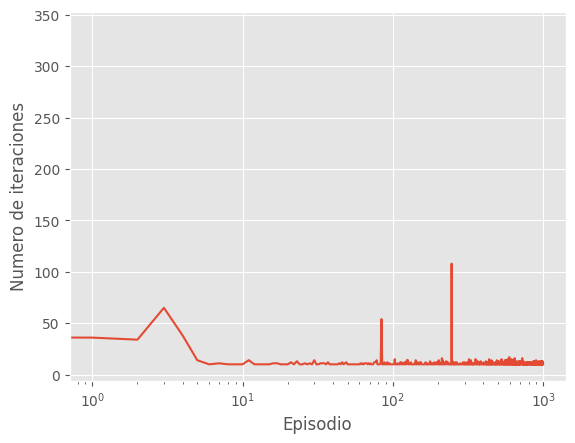

In [19]:
print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")
print(f"Ultima iteracion: {num_iteraciones}")

graficar_resultados(num_iteraciones_episodios)

Podemos observar como en los primeros episodios el agente logra completar el juego en muchas menos iteraciones comparado a cuando lo entrenamos por primera vez con otra semilla, esto es debido a que si bien la semilla cambia donde el agente debe recoger y dejar al pasajero el resto del ambiente permanece igual, por lo que el agente ya tiene una idea de como moverse en el ambiente.

Por otro lado, mirando lo negativo, se puede ver como el agente no logra converger a un rendimiento óptimo, sino que se mantiene en un rendimiento aceptable con fluctuaciones entre episodios, esto se debe a que esta sesgado por el previo entrenamiento con otra semilla y no explora lo suficiente, por lo que no logra encontrar la mejor solución.

En conclusión, podemos decir que el agente muestra mejoras en los primeros episodios con la nueva semilla pero no logra converger a un rendimiento óptimo.

### 4.4
Realizar los cambios necesarios para que el agente sea capaz de tener un
buen desempeño utilizando una semilla arbitraria. Ejecutar iteraciones
utilizando semillas arbitrarias y discutir los resultados. Agregar un nuevo
bloque de texto discutiendo los resultado obtenidos.

* Generalización vs Overfitting

Una estrategia para lograr que el agente tenga un buen desempeño frente a semillas arbitrarias es entrenarlo con muchas distintas. 

De esta manera el agente tendrá la oportunidad de explorar el ambiente en distintas situaciones y condiciones iniciales, adquiriendo un conocimiento más completo y robusto. 
Al entrenarlo con múltiples semillas arbitrarias, lo expondremos a una variedad de factores aleatorios que obligarán al agente a generalizar por encima de memorizar, esto debería conllevar a una mejora en su política de toma de decisiones de manera que no se sesgue por un entrenamiento previo.

* Fine Tuning de Hiperparámetros

Por otro lado, podemos variar algunos hiperpárametros del algoritmo. 

Por ejemplo, utilizar un factor de aprendizaje más bajo implicará una disminución más lenta de la probabilidad de exploración y por ende mayor exploración del ambiente, logrando que el agente aprenda a realizar la tarea de manera más general.

De forma similar, valores de gamma más altos priorizarán recompensas futuras, lo que puede ayudar en la generalización mientras que valores más bajos priorizarán recompensas inmediatas, y por ende, debería resultar en un aprendizaje más sesgado hacia la semilla actual.

In [20]:
def get_exploration_percentage(agente, threshold=0.05):
    # cantidad de celdas "exploradas", es decir, que tienen un valor distinto de 0
    total_celdas = agente.q_table.size
    # np.count_nonzero(agente.q_table)
    # cantidad de celdas con valor mayor a threshold
    exploradas = np.count_nonzero((agente.q_table > threshold) | (agente.q_table < -threshold))
    # porcentaje de exploracion
    return exploradas / total_celdas
    
def distribution_q_table(agente, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.hist(agente.q_table.flatten(), bins=100)

def cumulative_distribution_q_table(agent, ax=None):
    # Obtén los valores únicos de la tabla Q y cuenta cuántas celdas tienen cada valor
    unique_values, counts = np.unique(agent.q_table, return_counts=True)
    # Ordena los valores únicos en orden ascendente
    sorted_values = np.sort(unique_values)
    # Calcula la acumulación de las frecuencias
    cumulative_counts = np.cumsum(counts)
    # Normaliza los conteos acumulados para que estén en el rango [0, 1]
    cumulative_percentage = cumulative_counts / cumulative_counts[-1]
    # Crea el gráfico de distribución acumulada
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(sorted_values, cumulative_percentage, marker='o', linestyle='-')
    ax.set_xlabel('Valor en la Q-table')
    ax.set_ylabel('Porcentaje acumulado de celdas')
    ax.set_title('Distribución Acumulada de Valores en la Q-table')
    ax.grid(True)
    
def plot_q_table_stats(agente):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    cumulative_distribution_q_table(agente, ax[0])
    distribution_q_table(agente, ax[1])
    plt.show()


In [21]:
import time

# Agent Base, entrenado con semilla 1
agente_base = AgenteRL(entorno)
semilla = 1

num_iteraciones_episodios, tiempo_por_episodio = [], []
for i in range(1000):
    start_time = time.time()
    num_iteraciones = ejecutar_episodio(agente_base, semilla)
    tiempo_por_episodio.append(time.time() - start_time)
    num_iteraciones_episodios.append(num_iteraciones)

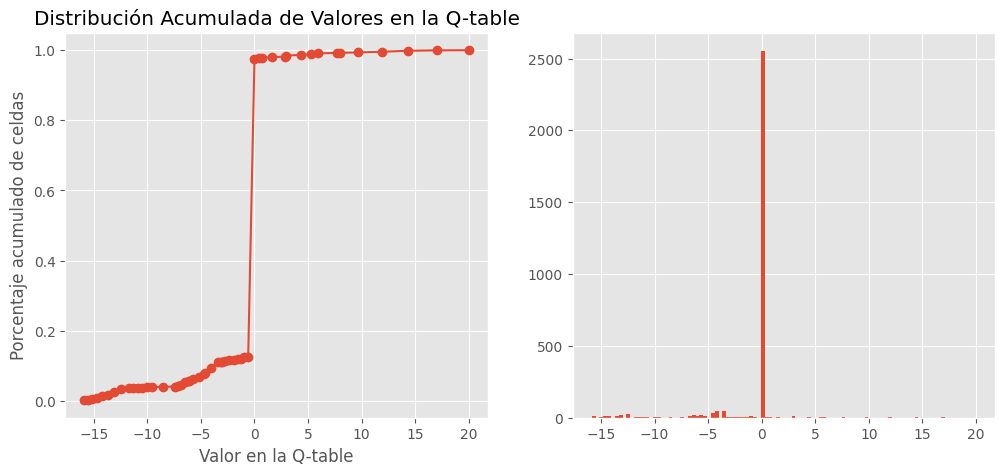

In [22]:
plot_q_table_stats(agente_base)

In [23]:
get_exploration_percentage(agente_base)

0.14933333333333335

Aquí podemos observar como el entrenar al agente sobre una única semilla resulta en un aprendizaje sesgado, la q table esta poco poblada lo que indica que el agente no exploró lo suficiente el ambiente y por ende dificilmente logrará desempenarse bien frente a otras semillas.

In [24]:
nro_semillas_distintas_vistas_durante_entrenamiento = [1000, 500, 100 , 1]
exploration_rates = [0.01, 0.05, 0.1, ]
gammas = [0.99, 0.7, ]

In [84]:
agentes = {}
seeds = np.arange(1_000_000)

for nro_semillas in nro_semillas_distintas_vistas_durante_entrenamiento:
    # generate nro_semillas unique random seeds
    unique_seeds = np.random.choice(seeds, size=nro_semillas, replace=False)
    for exp_rate in exploration_rates:
        for gamma in gammas:
            print(f"Agente con {nro_semillas} semillas, exploration_rate={exp_rate}, gamma={gamma}")
            agente = AgenteRL(entorno, exploration_rate=exp_rate, gamma=gamma)
            num_iteraciones_episodios, tiempo_por_episodio = [], []
            for i in range(1_000):
                seed = int(unique_seeds[i % nro_semillas])
                start_time = time.time()
                num_iteraciones = ejecutar_episodio(agente, seed)
                tiempo_por_episodio.append(time.time() - start_time)
                num_iteraciones_episodios.append(num_iteraciones)
            agentes[(nro_semillas, exp_rate, gamma)] = {
                'agente': agente,
                'nro_semillas': nro_semillas,
                'exploration_rate': exp_rate,
                'gamma': gamma,
                'num_iteraciones_episodios': num_iteraciones_episodios,
                'tiempo_por_episodio': tiempo_por_episodio,
            }

Agente con 1000 semillas, exploration_rate=0.01, gamma=0.99
Agente con 1000 semillas, exploration_rate=0.01, gamma=0.7
Agente con 1000 semillas, exploration_rate=0.05, gamma=0.99
Agente con 1000 semillas, exploration_rate=0.05, gamma=0.7
Agente con 1000 semillas, exploration_rate=0.1, gamma=0.99
Agente con 1000 semillas, exploration_rate=0.1, gamma=0.7
Agente con 500 semillas, exploration_rate=0.01, gamma=0.99
Agente con 500 semillas, exploration_rate=0.01, gamma=0.7
Agente con 500 semillas, exploration_rate=0.05, gamma=0.99
Agente con 500 semillas, exploration_rate=0.05, gamma=0.7
Agente con 500 semillas, exploration_rate=0.1, gamma=0.99
Agente con 500 semillas, exploration_rate=0.1, gamma=0.7
Agente con 100 semillas, exploration_rate=0.01, gamma=0.99
Agente con 100 semillas, exploration_rate=0.01, gamma=0.7
Agente con 100 semillas, exploration_rate=0.05, gamma=0.99
Agente con 100 semillas, exploration_rate=0.05, gamma=0.7
Agente con 100 semillas, exploration_rate=0.1, gamma=0.99
Agen

In [70]:
# saving the results
import csv
with open('experimentos.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['nro_semillas', 'exploration_rate', 'gamma', 'num_iteraciones_episodios', 'tiempo_por_episodio'])
    for key, value in agentes.items():
        writer.writerow([value['nro_semillas'], value['exploration_rate'], value['gamma'], value['num_iteraciones_episodios'], value['tiempo_por_episodio']])

In [71]:
import pandas as pd
from ast import literal_eval

results = {}
with open('experimentos.csv', 'r') as f:
    reader = csv.reader(f)
    header = next(reader)  # Skip the header
    for row in reader:
        nro_semillas, exp_rate, gamma, num_iteraciones_str, tiempo_por_episodio_str = row
        
        results[(int(nro_semillas), float(exp_rate), float(gamma))] = {
            'nro_semillas': int(nro_semillas),
            'exploration_rate': float(exp_rate),
            'gamma': float(gamma),
            'num_iteraciones_episodios': literal_eval(num_iteraciones_str),
            'tiempo_por_episodio': literal_eval(tiempo_por_episodio_str),
        }
df = pd.DataFrame.from_dict(results, orient='index')

In [72]:
# add mean and std columns
df['mean_iteraciones'] = df['num_iteraciones_episodios'].apply(np.mean)
df['std_iteraciones'] = df['num_iteraciones_episodios'].apply(np.std)
df['mean_tiempo'] = df['tiempo_por_episodio'].apply(np.mean)
df['mean_std'] = df['tiempo_por_episodio'].apply(np.std)

# add exploration percentage column
for config in df.index:
    df.loc[config, 'exploration_percentage'] = get_exploration_percentage(agentes[config]['agente'])

/tmp/ipykernel_236534/288096925.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[config, 'exploration_percentage'] = get_exploration_percentage(agentes[config]['agente'])
/tmp/ipykernel_236534/288096925.py:9: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[config, 'exploration_percentage'] = get_exploration_percentage(agentes[config]['agente'])


In [73]:
def plot_experiment(ax, row):
    nro_semillas = row['nro_semillas']
    exp_rate = row['exploration_rate']
    gamma = row['gamma']
    num_iteraciones = row['num_iteraciones_episodios']
    title = f"{nro_semillas} semillas, exp_rate={exp_rate}, gamma={gamma}"
    ax.set_xscale('log')
    ax.plot(np.arange(1, len(num_iteraciones) + 1), num_iteraciones)
    ax.set_xlabel('Episodio')
    ax.set_ylabel('Numero de Iteraciones')
    ax.set_title(title, fontsize=9)

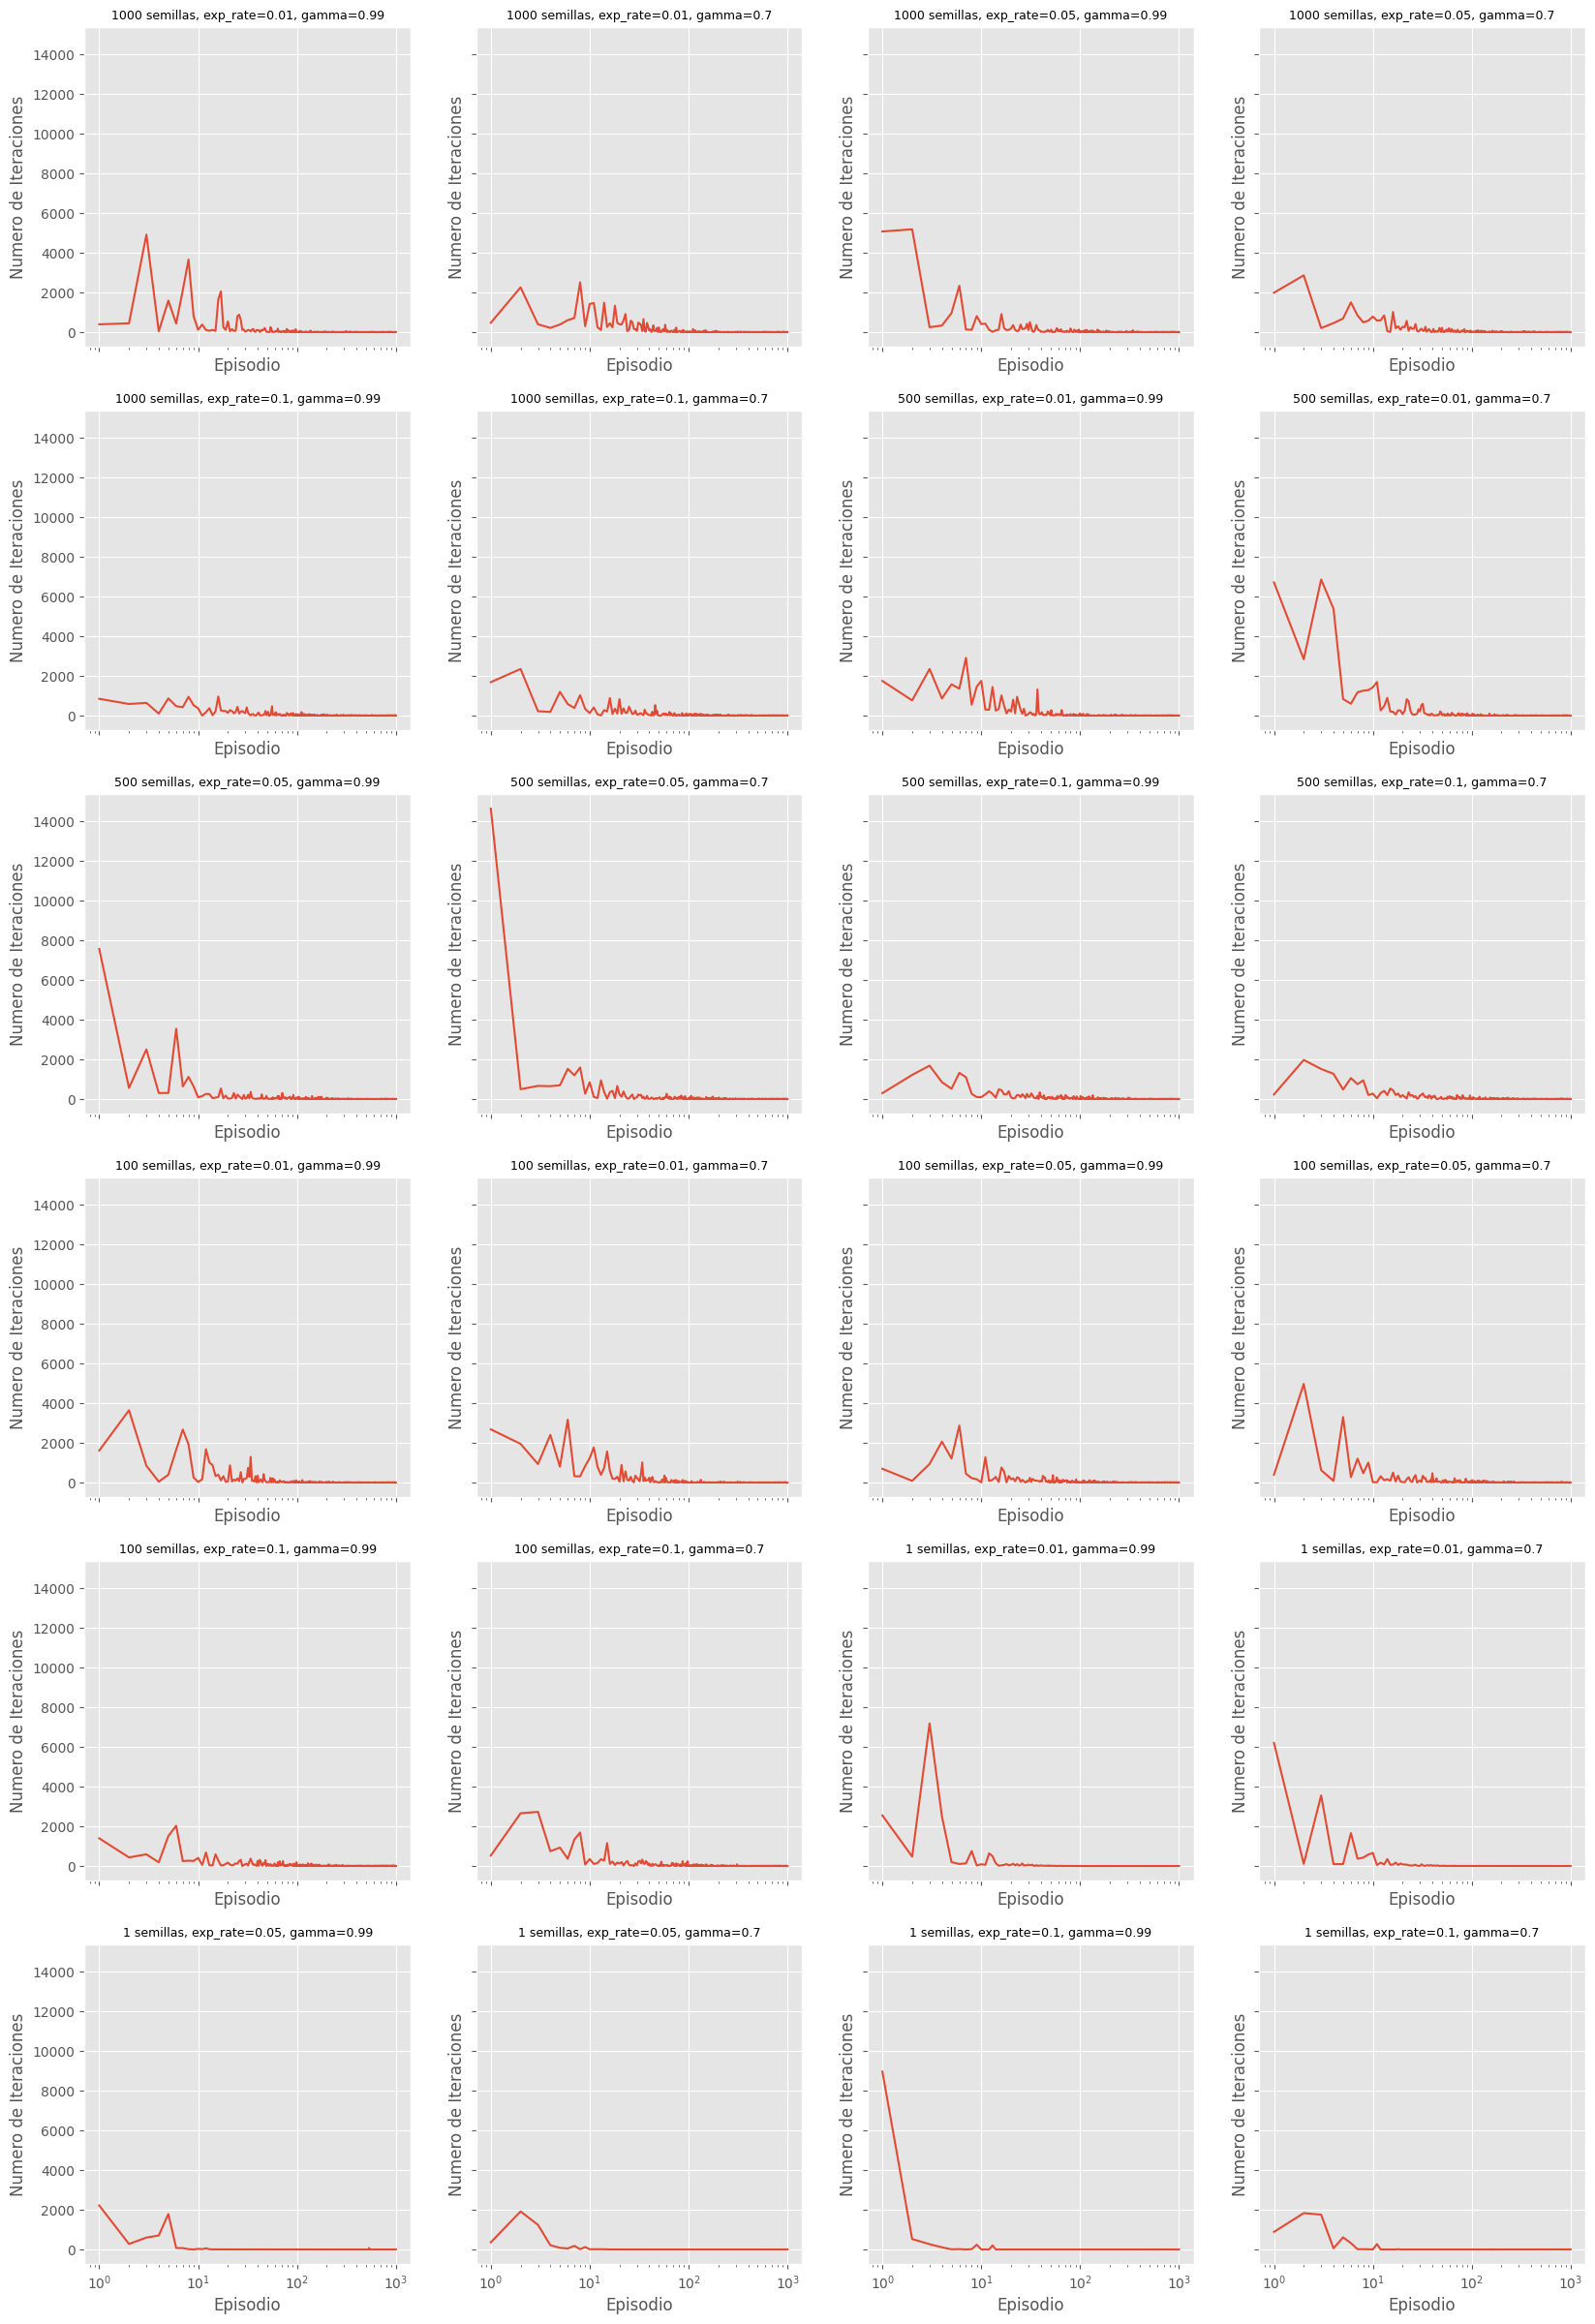

In [74]:
nrows = 6 # df.shape[0]
fig, axs = plt.subplots(nrows, 4, figsize=(20, 30), sharex=True, sharey=True)

for row_idx, ax in enumerate(axs.flat):
    row = df.iloc[row_idx]
    plot_experiment(ax, row)
    
plt.show()

In [75]:
def aggregated_metrics(group_by):
    df_agg1 = df.groupby(group_by).agg({'exploration_percentage': 'mean'}).sort_values(by='exploration_percentage', ascending=False)
    df_agg2 = df.groupby(group_by).agg({'mean_iteraciones': 'mean'}).sort_values(by='mean_iteraciones', ascending=True)
    df_agg3 = df.groupby(group_by).agg({'mean_tiempo': 'mean'}).sort_values(by='mean_tiempo', ascending=True)

    # display results
    display(pd.DataFrame({'Exploration Percentage Mean': df_agg1['exploration_percentage']}))
    display(pd.DataFrame({'Mean Iteraciones': df_agg2['mean_iteraciones']}))
    display(pd.DataFrame({'Mean Tiempo': df_agg3['mean_tiempo']}))

In [76]:
aggregated_metrics('nro_semillas')

,Exploration Percentage Mean
nro_semillas,
1000,0.799389
100,0.799111
500,0.798889
1,0.186056


,Mean Iteraciones
nro_semillas,
1,20.499500
100,36.907500
1000,36.907667
500,41.638667


,Mean Tiempo
nro_semillas,
1,0.013868
100,0.015358
1000,0.015688
500,0.016163


Podemos remarcar un par de observaciones:

* Cuantas menos semillas utilicemos en el entrenamiento, más rápido completará el entrenamiento. Esto es esperable dado que una vez que el agente aprende a realizar la tarea en dicho entorno no tiene necesidad de seguir explorando caminos. Lo mismo sucede con el promedio del número de iteraciones por episodio, y es entendible que estas dos métricas estén relacionadas.

* Sorprendentemente, podemos ver que el porcentaje de la q table poblada no es tan distinto a medida que aumenta el número de semillas. De 1 a 100 hay un gran salto pero luego se mantiene practicamente constante, de todos modos, hay que tomar en cuenta que la condición de consideración de una celda como poblada es que tenga un valor en el intervalo $(-0.05, 0.05)$ lo que no es un representativo directo de la cantidad de información que se tiene sobre la celda. 

In [77]:
aggregated_metrics('gamma')

,Exploration Percentage Mean
gamma,
0.70,0.646611
0.99,0.645111


,Mean Iteraciones
gamma,
0.99,33.331583
0.70,34.645083


,Mean Tiempo
gamma,
0.99,0.015191
0.70,0.015348


In [78]:
aggregated_metrics('exploration_rate')

,Exploration Percentage Mean
exploration_rate,
0.01,0.649458
0.10,0.649083
0.05,0.639042


,Mean Iteraciones
exploration_rate,
0.10,29.186250
0.05,33.010375
0.01,39.768375


,Mean Tiempo
exploration_rate,
0.10,0.014251
0.05,0.014618
0.01,0.016938


En cuanto a los otros dos hiperparámetros considerados no se observa una difrencia significativa en el desempeño del agente.

En conclusión, es claro que utilizar una única semilla para entrenar al agente no es una buena idea si lo que se busca es que este se desempeñe bien frente a semillas arbitrarias. 

Por otro lado, un mayor factor de exploración y un mayor valor gamma suelen favorecer la exploración pero no se observa (con los valores experimentados) una mejora significativa.

Finalmente veamos el desempeño de los distintos agentes sobre una semilla arbitraria no utilizada durante el entrenamiento.

In [85]:
# evaluar los agentes sobre esta nueva semilla
semilla = 1_000_001

test_results = {}
for key, val in agentes.items():
    agente = val['agente']
    num_iteraciones_episodios, tiempo_por_episodio = [], []
    for i in range(100):
        start_time = time.time()
        num_iteraciones = ejecutar_episodio(agente, semilla)
        tiempo_por_episodio.append(time.time() - start_time)
        num_iteraciones_episodios.append(num_iteraciones)
    test_results[key] = {
        'agente': agente,
        'nro_semillas': val['nro_semillas'],
        'exploration_rate': val['exploration_rate'],
        'gamma': val['gamma'],
        'num_iteraciones_episodios': num_iteraciones_episodios,
        'tiempo_por_episodio': tiempo_por_episodio,
    }

In [86]:
test_df = pd.DataFrame.from_dict(test_results, orient='index')

In [87]:
test_df['mean_iteraciones'] = test_df['num_iteraciones_episodios'].apply(np.mean)
# sort by mean_iteraciones to find the best agent
test_df.sort_values(by='mean_iteraciones', ascending=True, inplace=True)

In [98]:
test_df[["mean_iteraciones"]]

mean_iteraciones
100  0.01 0.99             12.49
     0.05 0.99             12.61
500  0.10 0.70             12.63
100  0.05 0.70             12.63
500  0.01 0.99             12.67
1000 0.10 0.99             12.70
          0.70             12.71
500  0.01 0.70             12.71
100  0.01 0.70             12.75
     0.10 0.70             12.83
500  0.05 0.70             12.84
1000 0.05 0.99             13.01
     0.01 0.70             13.02
          0.99             13.15
500  0.05 0.99             13.65
1000 0.05 0.70             13.91
500  0.10 0.99             14.43
100  0.10 0.99             14.63
1    0.01 0.99             29.80
     0.10 0.99             33.98
     0.01 0.70             34.47
     0.05 0.70             34.58
     0.10 0.70             36.07
     0.05 0.99             37.28

Confirmando lo observado anteriormente, el agente entrenado con una única semilla es quien peor se desempeña frente a la semilla arbitraria, mientras que el agente entrenado con 100 semillas es quien mejor lo realiza.